# CONFIGURANDO O AMBIENTE

## ACESSANDO DATAFRAME DO DRIVE

In [ ]:
from google.colab import drive
# Montando o drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/drive/My Drive/csv/carros.csv')

## TRATANDO O DATA FRAME

In [ ]:
# Corrigindo os Preços

# Criando DataFrame de Valores Centrais
dfVCPreco = df[ (df['Preço'] >= df['Preço'].quantile(0.01) ) & (df['Preço'] < df['Preço'].quantile(0.99) ) ]
# Definindo a média
mediaPreco = dfVCPreco['Preço'].mean()
# Definindo o limites para considerar um outlier
limiteL = df['Preço'].quantile(0.25) / 2
limiteU = df['Preço'].quantile(0.75) * 5
# Trocando os outliers pela média dos valores centrais
df['Preço'] = df['Preço'].apply(lambda x: mediaPreco if (x < limiteL) or (x > limiteU) else x)

In [ ]:
# Corrigindo as Quilometragens

# Criando DataFrame de Valores Centrais
dfVCKM = df[ df['Quilometragem'] <= df['Quilometragem'].quantile(0.99) ]
# Definindo a média
mediaKM = dfVCKM['Quilometragem'].mean()
# Definindo o limite para ser outlier
limiteU = df['Quilometragem'].quantile(0.75) * 5
# Trocando os outliers pela média dos Valores Centrais
df['Quilometragem'] = df['Quilometragem'].apply(lambda x: mediaKM if x > limiteU else x)

In [ ]:
# Escolhendo as colunas para padronizar
colunas = df[ ['Ano Modelo', 'Quilometragem' ] ]
# Padronizando as colunas pelo método Z-score
scaler = StandardScaler()
colunasEscaladas = scaler.fit_transform(colunas)
# Criando um DataFrame com as colunas padronizadas
dfTratado = pd.DataFrame( colunasEscaladas, columns=['AnoModelo', 'Quilometragem'])
# Adicionando a coluna alvo no DataFrame
dfTratado['Preço'] = df['Preço']

# REGRESSÃO LINEAR

## IMPORTANDO BIBLIOTECAS PARA REGRESSÃO LINEAR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## APLICANDO REGRESSÃO LINEAR UNIVARIADA

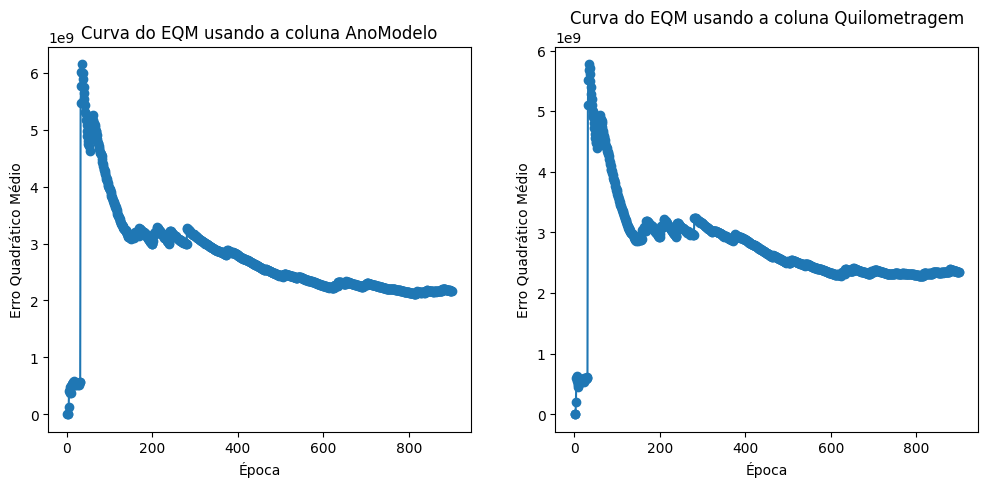

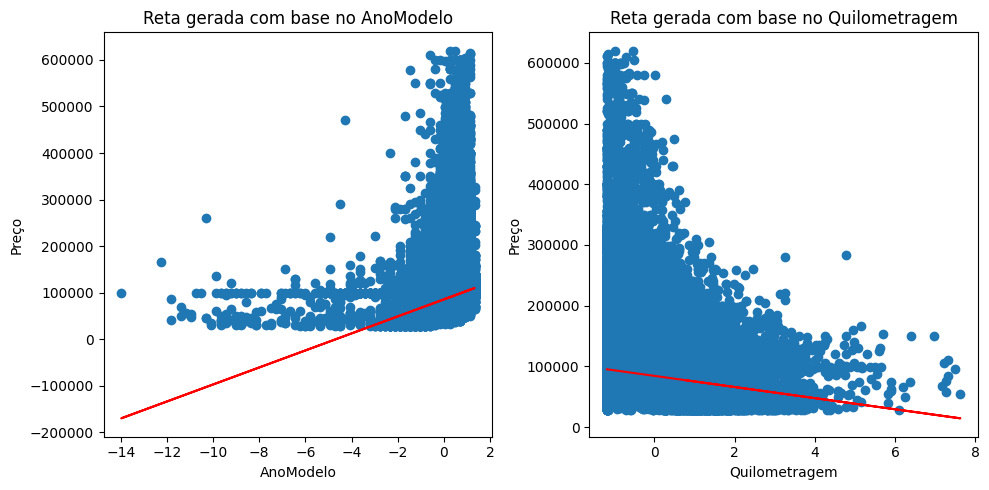

In [ ]:
# Definindo as colunas que serão utilizadas como coluna de treinamento
colunas = ['AnoModelo', 'Quilometragem']
# Criando as figuras onde serão exibidos os gráficos
fig1, axs1 = plt.subplots(1, 2, figsize=(12, 5))
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))

for i, coluna in enumerate(colunas):
  # Separando as colunas de treinamento e alvo
  X = dfTratado[coluna].values.reshape(-1, 1)
  y = dfTratado['Preço'].values

  modelo = LinearRegression()
  # Criando lista para o EQM e para as iterações
  listaEQM = []
  iter = []
  # Treinando o modelo
  for epoca in range(1,901):
      modelo.fit(X[:epoca], y[:epoca])
      previsoes = modelo.predict(X[:epoca])
      mse = mean_squared_error(y[:epoca], previsoes)
      listaEQM.append(mse)
      iter.append(epoca)
  # Plotando a curva do EQM
  axs1[i].plot(iter, listaEQM, marker='o')
  axs1[i].set_xlabel('Época')
  axs1[i].set_ylabel('Erro Quadrático Médio')
  axs1[i].set_title('Curva do EQM usando a coluna ' + coluna)
  # Plotando os dados e a linha gerada pela regressão
  axs2[i].scatter(X, y)
  axs2[i].plot(X, modelo.predict(X), color='red')
  axs2[i].set_xlabel(coluna)
  axs2[i].set_ylabel('Preço')
  axs2[i].set_title('Reta gerada com base no ' + coluna)
# Ajustando e exibindo os gráficos
plt.tight_layout()
plt.show()
plt.show()

# ÁRVORE DE DECISÃO

## IMPORTANDO BIBLIOTECAS PARA ÁRVORE DE DECISÃO

In [ ]:
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## APLICANDO MODELO DE ÁRVORE DE DECISÃO

In [ ]:
# Funcão que aplica o modelo de árvore de decisão
def dtNum(X, y, categoricas):
  # Separando as variáveis de treino e de teste
  Xtreino, Xteste, ytreino, yteste = train_test_split(X, y, test_size=0.2, random_state=42)
  # Processando as colunas categóricas para poder aplicar o modelo
  processamento = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), categoricas)],
    remainder='passthrough'
  )
  # Ajustando as colunas de treino e de teste de acordo com o processamento
  Xtreino = processamento.fit_transform(Xtreino)
  Xteste = processamento.transform(Xteste)
  # Criando modelo
  modelo = DecisionTreeRegressor()
  # Treinando o modelo
  modelo.fit(Xtreino, ytreino)
  # Guardando as predições
  predicoes = modelo.predict(Xteste)
  # Calculando o EQM
  eqm = mean_squared_error(yteste, predicoes)
  # Calculando r2
  r2 = r2_score(yteste, predicoes)

  return eqm, r2

In [ ]:
# Definindo as colunas de treinamento
X = df[ ['Marca', 'Ano Modelo', 'Quilometragem', 'Câmbio', 'Combustível'] ]
# Definindo as colunas alvo
y = df['Preço']
# Declarando as variáveis categóricas
categoricas = ['Marca', 'Câmbio', 'Combustível']
# Aplicando o modelo
mse, r2 = dtNum(X, y, categoricas)
# Exibindo resultados
print('Erro quadrático médio: ', round(mse, 1) )
print('Raiz do EQM          : ', round(math.sqrt(mse), 1) )
print('r2                   : ', r2)

Erro quadrático médio:  1669036186.5
Raiz do EQM          :  40853.8
r2                   :  0.6859606448893563


In [ ]:
# Definindo as colunas de treinamento
X = df[ ['Marca', 'Preço', 'Ano Modelo', 'Câmbio', 'Combustível'] ]
# Definindo as colunas alvo
y = df['Quilometragem']
# Declarando as variáveis categóricas
categoricas = ['Marca', 'Câmbio', 'Combustível']
# Aplicando o modelo
mse, r2 = dtNum(X, y, categoricas)
# Exibindo resultados
print('Erro quadrático médio: ', round(mse, 1) )
print('Raiz do EQM          : ', round(math.sqrt(mse), 1) )
print('r2                   : ', r2)

Erro quadrático médio:  1894320862.1
Raiz do EQM          :  43523.8
r2                   :  0.38721599046593336


In [ ]:
# Definindo as colunas de treinamento
X = df[ ['Marca', 'Preço', 'Quilometragem', 'Câmbio', 'Combustível'] ]
# Definindo as colunas alvo
y = df['Ano Fabricação']
# Declarando as variáveis categóricas
categoricas = ['Marca', 'Câmbio', 'Combustível']
# Aplicando o modelo
mse, r2 = dtNum(X, y, categoricas)
# Exibindo resultados
print('Erro quadrático médio: ', round(mse, 1) )
print('Raiz do EQM          : ', round(math.sqrt(mse), 1) )
print('r2                   : ', r2)

Erro quadrático médio:  8.8
Raiz do EQM          :  3.0
r2                   :  0.5769859385292151


In [ ]:
# Definindo as colunas de treinamento
X = df[ ['Marca', 'Preço', 'Quilometragem', 'Câmbio', 'Combustível'] ]
# Definindo as colunas alvo
y = df['Ano Modelo']
# Declarando as variáveis categóricas
categoricas = ['Marca', 'Câmbio', 'Combustível']
# Aplicando o modelo
mse, r2 = dtNum(X, y, categoricas)
# Exibindo resultados
print('Erro quadrático médio: ', round(mse, 1) )
print('Raiz do EQM          : ', round(math.sqrt(mse), 1) )
print('r2                   : ', r2)

Erro quadrático médio:  9.1
Raiz do EQM          :  3.0
r2                   :  0.5634141736655534
